# Objective- Implement SGD to Linear Regression

About the dataset-
--------------------

Boston House Prices dataset
---------------------------

Notes
------
Data Set Characteristics:  

    1. Number of Instances: 506 

    2. Number of Attributes: 13 numeric/categorical predictive
    
    3. Median Value (attribute 14) is usually the target

    4. Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's


In [52]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# loading boston datasets
from sklearn.datasets import load_boston
import pandas as pd


In [53]:
boston_price_data = load_boston()

# spliting the data into train and test
boston_data = pd.DataFrame(data = boston_price_data.data)

boston_data[13] = boston_data[10] // boston_data[12]

price = boston_price_data.target
X_train, X_test, y_train, y_test = train_test_split(boston_data, price, test_size=0.33, random_state=10)


In [54]:
# applying column standardization on train and test data
scale = StandardScaler()
X_train = scale.fit_transform(np.array(X_train))
X_test = scale.transform(np.array(X_test))


In [55]:
#preparing training data for manual sgd regressor
X_train_manual = pd.DataFrame(data = X_train)
X_train_manual['price'] = y_train
X_train_manual.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,price
0,-0.136415,-0.47928,1.167876,-0.250392,2.749511,-1.992829,0.964187,-1.103664,-0.540043,-0.058172,-1.777315,0.392614,2.365979,-1.156506,14.6
1,-0.417778,-0.47928,-1.180433,-0.250392,-0.830671,-0.165953,-1.294382,0.966408,-0.653052,0.098893,-0.759875,0.147219,-0.541158,-0.361262,19.8
2,1.312692,-0.47928,0.955177,-0.250392,1.259946,-2.061824,1.117129,-1.043290,1.607129,1.471764,0.766286,0.193350,2.521007,-1.156506,10.2


In [56]:
# converting to numpy array, which will be available for both SGDRegressor of sklearn and manual sgd regressor
X_test = np.array(X_test)
y_test = np.array(y_test)

In [57]:
y_test.shape

(167,)

In [58]:
output_matrix = pd.DataFrame(columns=['S/No', 'Algorithm', 'alpha', 'lr_rate_variation', 'init_lr_rate', 'power_t', 'n_iter', 'error'])

## [SGDRegressor vs manual sgd]

#  Experiment 1:
* fixing initial learning rate to 0.01 and changing number of iterations


In [59]:
b_diff = []
w_diff = []

In [60]:
#the functioning of this function is to use sklearn SGDRegressor and predict the price
#this function takes alpha, learning rate variation , initial learning rate(eta0), number of iteration , power_t, and all test and train data as an argument
#this function returns weight, intercept and mean squared error
def sklearn_implemention_sgd(train_data, test_data, train_y, test_y, alpha, learn_rate, eta0 , n_iteration ):
    clf = SGDRegressor(alpha = alpha, penalty=None, learning_rate = learn_rate, eta0 = eta0, max_iter = n_iteration)
    clf.fit(train_data, train_y)
    pred_y = clf.predict(test_data)
    
    #scatter plot
    plt.scatter(test_y , pred_y)
    plt.title('Scatter Plot between observed output(y) and predicted output(y)')
    plt.xlabel('Observed y')
    plt.ylabel('Predicted y')
    plt.grid(b=True, linewidth=0.5)
    plt.show()
    print('***********************************************************')
    #kdeplot
    sgd_error = mean_squared_error(test_y , pred_y)
    print('Mean sq error =', sgd_error)
    print('Max Number of iteration =', n_iteration)
    return clf.coef_, clf.intercept_, sgd_error


### 1.1 SGDRegressor with  n_iter = 100

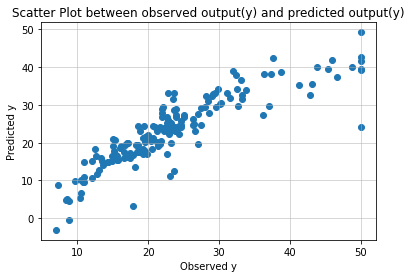

***********************************************************
Mean sq error = 22.04770858149201
Max Number of iteration = 100


In [61]:
coeff_w, intercept_b, sgd_error = sklearn_implemention_sgd(X_train , X_test ,y_train,y_test,alpha=0.0001, \
                                                           learn_rate='constant', eta0=0.01 , n_iteration=100 )

In [62]:
new_result_1 = [1, 'SGDRegressor', 0.0001, 'constant', 0.01, 0.25, 100, sgd_error]
output_matrix.loc[0] = new_result_1

### 1.2 Manual SGD with  n_iter = 100

In [63]:
# this function is a simple implementation of sgd to linear regression, here we didn't use any regularization
# we need to provide the pandas data with price, initial learning rate , and learning rate variation, number of iteration
# here we have implemented constant learning rate and invscaling learning rate
# checking the significant difference in loss i.e stopping condition might take lots of time so here we fix the number of loop 
# this function returns weight (w) and bias (b)
# here we have taken sgd with batch size=10

# ‘invscaling’:
# eta = eta0 / pow(t, power_t) where eta0 = initial learning index ,power_t = The exponent for inverse scaling learning rate.

def manual_sgd(X, learn_rate , alpha = 0.0001, learn_rate0 = 0.01, power_t = 0.25, max_iter = 100):
    w_new = np.zeros(shape=(1,14))
    b_new = 0
    t = 1
    r = learn_rate0
    batch_size = 25
    
    while(t <= max_iter):
        w_old = w_new
        b_old = b_new
        w_ = np.zeros(shape=(1,14))
        b_ = 0
        x_data = X.sample(batch_size)
        x = np.array(x_data.drop('price',axis=1))
        y = np.array(x_data['price'])
        
        for i in range(batch_size): 
            y_curr = np.dot(w_old,x[i]) + b_old
            w_ += x[i] * (y[i] - y_curr)
            b_ += (y[i]-y_curr)      
            
        w_ *= (-2/x.shape[0])
        b_ *= (-2/x.shape[0])
        
        #updating the parameters
        w_new = (w_old-r*w_/batch_size)
        b_new = (b_old-r*b_/batch_size)
        
        if(learn_rate=='invscaling'):
            r = learn_rate0 / pow(t, power_t)
        t+=1
        
    return w_new, b_new


def predict( x , w , b):
    y_pred=[]
    for i in range(len(x)):
        y=np.asscalar(np.dot(w,x[i])+b)
        y_pred.append(y)
    return np.array(y_pred)

def plot_scatter(test_y , y_pred):
    #scatter plot
    plt.scatter(test_y , y_pred)
    plt.grid(b = True, linewidth = 0.3)
    plt.title('scatter plot between actual y and predicted y')
    plt.xlabel('Observed y')
    plt.ylabel('Predicted y')
    plt.show()
    print('**************************************************************')
    manual_error = mean_squared_error(test_y , y_pred)
    print('Error =', manual_error)
    return manual_error


In [64]:
w, b = manual_sgd(X = X_train_manual, learn_rate = 'constant' , max_iter = 100)

In [65]:
y_pred = predict(X_test, w,  b)

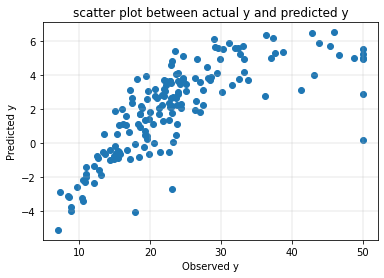

**************************************************************
Error = 524.7262908280684


In [66]:
manual_error = plot_scatter(y_test , y_pred)

In [67]:
new = [2, 'manual sgd', 0.0001, 'constant', 0.01, 0.25, 100, manual_error]
output_matrix.loc[1] = new

In [68]:
percent=abs((coeff_w - w)/w)*100
cnt = 0
for i in range(13):
    if (percent[0][i]>30):
        cnt+=1
w_diff.append(cnt)
print('number of weights with more than 30% percent difference =',cnt)

number of weights with more than 30% percent difference = 13


In [69]:
print('sklearn sgd intercept=',intercept_b)
print('manual sgd intercept=',b)
b_diff.append(abs(intercept_b - b))

sklearn sgd intercept= [21.93815788]
manual sgd intercept= [1.69662787]


### 1.3 SGDRegressor with n_iter=1000

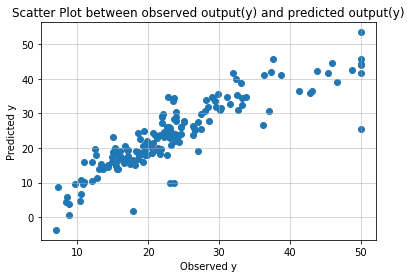

***********************************************************
Mean sq error = 23.346104406479302
Max Number of iteration = 1000


In [70]:
coeff_w, intercept_b, sgd_error = sklearn_implemention_sgd(X_train , X_test ,y_train,y_test,alpha=0.0001, \
                                                           learn_rate='constant', eta0=0.01 , n_iteration=1000 )

In [71]:
new = [3, 'SGDRegressor', 0.0001, 'constant', 0.01, 0.25, 1000, sgd_error]
output_matrix.loc[2]=new

### 1.4 Manual SGD with n_iter = 1000

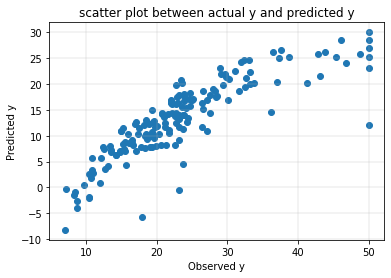

**************************************************************
Error = 131.8212185346562


In [72]:
w, b = manual_sgd(X = X_train_manual, learn_rate = 'constant' , max_iter = 1000)

y_pred = predict(X_test, w,  b)
manual_error = plot_scatter(y_test , y_pred)

In [73]:
percent=abs((coeff_w-w)/w)*100
cnt=0
for i in range(13):
    if (percent[0][i]>30):
        cnt+=1
w_diff.append(cnt)
print('number of points more than 30% in percent=',cnt)

number of points more than 30% in percent= 9


In [74]:
print('sklearn sgd intercept=',intercept_b)
print('manual sgd intercept=',b)
b_diff.append(abs(intercept_b-b))

sklearn sgd intercept= [22.32605766]
manual sgd intercept= [12.15843062]


In [75]:
new=[4, 'manual sgd', 0.0001, 'constant', 0.01, 0.25, 1000, manual_error]
output_matrix.loc[3]=new

### 1.5 SGDRegressor with n_iter = 10000

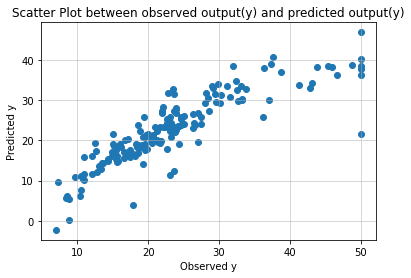

***********************************************************
Mean sq error = 23.782855766540965
Max Number of iteration = 10000


In [76]:
coeff_w, intercept_b, sgd_error = sklearn_implemention_sgd(X_train , X_test ,y_train,y_test,alpha=0.0001, \
                                                           learn_rate='constant', eta0=0.01 , n_iteration=10000 )

In [77]:
new=[5, 'SGDRegressor', 0.0001, 'constant', 0.01, 0.25, 10000, sgd_error]
output_matrix.loc[4]=new

### 1.6 Manual SGD with n_iter=10000

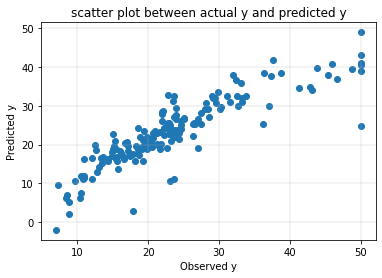

**************************************************************
Error = 21.636906836462845


In [78]:
w, b = manual_sgd(X = X_train_manual, learn_rate = 'constant' , max_iter = 10000)
y_pred = predict(X_test, w,  b)
manual_error = plot_scatter(y_test , y_pred)

In [79]:
print('sklearn sgd weight---\n',coeff_w)
print('*********************************************************************************')
print('manual sgd weight---\n',w)

sklearn sgd weight---
 [-1.31415772  1.36834779 -0.19276002 -0.28173018 -1.82101709  1.66048596
  0.38362001 -2.74098018  2.38617913 -1.72607455 -2.35968779  1.14913859
 -1.8302951   2.79284763]
*********************************************************************************
manual sgd weight---
 [[-1.12376584  0.73611693 -0.44724048  0.3510551  -1.08281982  1.97186721
   0.4193364  -2.32077627  1.20561163 -0.67020971 -2.06284716  1.13539415
  -1.90649753  3.03359616]]


In [80]:
percent=abs((coeff_w-w)/w)*100
cnt=0
for i in range(13):
    if (percent[0][i]>30):
        cnt+=1
w_diff.append(cnt)
print('number of points more than 30% chnage in weights=',cnt)

number of points more than 30% in percent= 6


In [81]:
print('sklearn sgd intercept=',intercept_b)
print('manual sgd intercept=',b)
b_diff.append(abs(intercept_b-b))

sklearn sgd intercept= [21.77275528]
manual sgd intercept= [22.08336101]


In [82]:
new=[6, 'manual sgd', 0.0001, 'constant', 0.01, 0.25, 10000, manual_error]
output_matrix.loc[5]=new

In [83]:
import tabulate
table_constant_lr = [['n_iter', 'no. of points>30% in w', 'difference in intercept'],
         [1,w_diff[0], b_diff[0]], 
         [100, w_diff[1], b_diff[1]],
         [1000, w_diff[2], b_diff[2]]]

In [84]:
print(tabulate.tabulate(table_constant_lr, tablefmt='fancy_grid'))

╒════════╤════════════════════════╤═════════════════════════╕
│ n_iter │ no. of points>30% in w │ difference in intercept │
├────────┼────────────────────────┼─────────────────────────┤
│ 1      │ 13                     │ [20.24153]              │
├────────┼────────────────────────┼─────────────────────────┤
│ 100    │ 9                      │ [10.16762704]           │
├────────┼────────────────────────┼─────────────────────────┤
│ 1000   │ 6                      │ [0.31060573]            │
╘════════╧════════════════════════╧═════════════════════════╛


In [85]:
output_matrix

,S/No,Algorithm,alpha,lr_rate_variation,init_lr_rate,power_t,n_iter,error
0,1,SGDRegressor,0.0001,constant,0.01,0.25,100,22.047709
1,2,manual sgd,0.0001,constant,0.01,0.25,100,524.726291
2,3,SGDRegressor,0.0001,constant,0.01,0.25,1000,23.346104
3,4,manual sgd,0.0001,constant,0.01,0.25,1000,131.821219
4,5,SGDRegressor,0.0001,constant,0.01,0.25,10000,23.782856
5,6,manual sgd,0.0001,constant,0.01,0.25,10000,21.636907


## Observation-
* We have fixed initial learning rate and lr_rate_variation, and only changing n_iter or number of iterations.
* We can see , by increasing the number of iterations for manual sgd, error is reducing significantly.
* By increasing the number of iterations ,manual sgd weight and SGDRegressor weight is going to be more similar
* By Increasing the number of iterations the intercept values also comes closer.


# ... for constant learning rate variation and 10000 iterations we get the least mse score for both SGDRegressor of sklearn and our custom SGD model. Also for this setting the weights in both model are quite similar.

# Mean Squared Error for manual SGD    in this case is 21.63 while that of sklearn SGDRegressor is 23.782

Infact there are only 6 weights which has more than 30% change in weights incustom model compared to Sklearn model

# Experiment 2:

* using optimal learning rate variation and changing the n_iter

In [86]:
b1_diff=[]
w1_num=[]

### 2.1 SGDRegressor with  n_iter=100 and lr_rate_variation='invscaling'

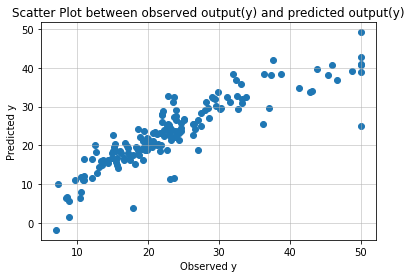

***********************************************************
Mean sq error = 21.305161698881506
Max Number of iteration = 100


In [87]:

coeff_w, intercept_b, sgd_error = sklearn_implemention_sgd(X_train , X_test ,y_train,y_test,alpha=0.0001, \
                                                           learn_rate='invscaling', eta0=0.01 , n_iteration=100 )

In [88]:
new=[7, 'SGDRegressor', 0.0001, 'invscaling', 0.01, 0.25, 100, sgd_error]
output_matrix.loc[6]=new

### 2.2 Manual SGD with n_iter = 100, initial learn_rate of 0.01  and lr_rate_variation='invscaling'

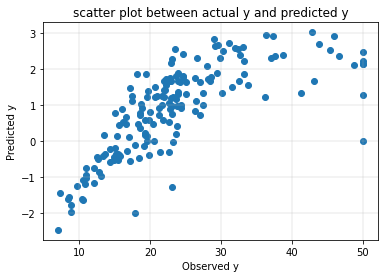

**************************************************************
Error = 589.6398025062791


In [89]:
w, b = manual_sgd(X=X_train_manual, learn_rate ='invscaling' , max_iter=100)
y_pred = predict(X_test, w, b)
manual_error=plot_scatter(y_test,y_pred)

In [90]:
new=[8, 'manual sgd', 0.0001, 'invscaling', 0.01, 0.25, 100, manual_error]
output_matrix.loc[7]=new

In [91]:
print('sklearn sgd weight---\n',coeff_w)
print('*********************************************************************************')
print('manual sgd weight---\n',w)

sklearn sgd weight---
 [-1.22161446  0.8438064  -0.37676547  0.33018879 -1.50614353  1.82081208
  0.48814683 -2.67131376  1.72417652 -0.9750997  -2.16098865  1.131362
 -1.831158    3.10283918]
*********************************************************************************
manual sgd weight---
 [[-0.10166651  0.11703976 -0.12305918  0.03607531 -0.11198859  0.17946447
  -0.12353386  0.07597705 -0.09869213 -0.12177261 -0.13893958  0.08989692
  -0.21109709  0.22026435]]


In [92]:
percent=abs((coeff_w-w)/w)*100
cnt=0
for i in range(13):
    if (percent[0][i]>30):
        cnt+=1
w_diff.append(cnt)
print('number of points more than 30% in percent=',cnt)

number of points more than 30% in percent= 13


In [93]:
print('sklearn sgd intercept=',intercept_b)
print('manual sgd intercept=',b)
b_diff.append(abs(intercept_b - b))

sklearn sgd intercept= [22.06793222]
manual sgd intercept= [0.73545573]


### 2.3 SGDRegressor with  n_iter=1000, initial learn_rate=0.01 and  lr_rate_variation='invscaling'

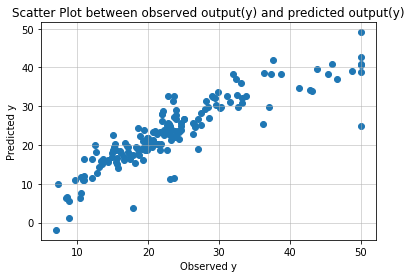

***********************************************************
Mean sq error = 21.420715143214636
Max Number of iteration = 1000


In [94]:

coeff_w, intercept_b, sgd_error = sklearn_implemention_sgd(X_train , X_test ,y_train,y_test,alpha=0.0001, \
                                                           learn_rate='invscaling', eta0=0.01 , n_iteration=1000 )

In [95]:
new=[9, 'SGDRegressor', 0.0001, 'invscaling', 0.01, 0.25, 1000, sgd_error]
output_matrix.loc[8]=new

### 2.4 Manual SGD with n_iter=1000, lr_rate=0.01, lr_rate_variation='invscaling'

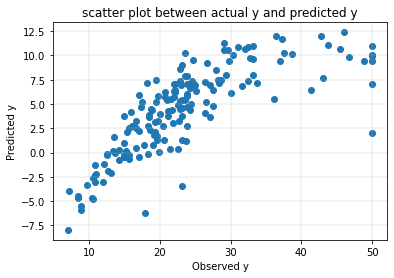

**************************************************************
Error = 414.0455286723952


In [96]:
w, b = manual_sgd(X=X_train_manual, learn_rate ='invscaling' , max_iter=1000)
y_pred = predict(X_test, w, b)
manual_error=plot_scatter(y_test,y_pred)

In [97]:
new = [10, 'manual sgd', 0.0001, 'invscaling', 0.01, 0.25, 1000, manual_error]
output_matrix.loc[9] = new

In [98]:
print('sklearn sgd weight---\n',coeff_w)
print('*********************************************************************************')
print('manual sgd weight---\n',w)

sklearn sgd weight---
 [-1.23137638  0.85010305 -0.41315182  0.32494746 -1.49476775  1.84434329
  0.46420577 -2.61613168  1.64634096 -0.93063298 -2.15582675  1.1327476
 -1.80596778  3.10793612]
*********************************************************************************
manual sgd weight---
 [[-0.36473548  0.43429451 -0.4547213   0.23682364 -0.37890466  0.7542144
  -0.33556994  0.17303539 -0.26191127 -0.38909566 -0.56349237  0.35443547
  -0.82208655  0.8606992 ]]


In [99]:
percent=abs((coeff_w-w)/w)*100
cnt=0
for i in range(13):
    if (percent[0][i]>30):
        cnt+=1
w_diff.append(cnt)
print('number of points more than 30% in percent=',cnt)

number of points more than 30% in percent= 12


In [100]:
print('sklearn sgd intercept=',intercept_b)
print('manual sgd intercept=',b)
b_diff.append(abs(intercept_b-b))

sklearn sgd intercept= [22.08306244]
manual sgd intercept= [3.81472306]


### 2.5 SGDRegressor, n_iter=10000, lr_rate=0.01, lr_rate_variation='invscaling'

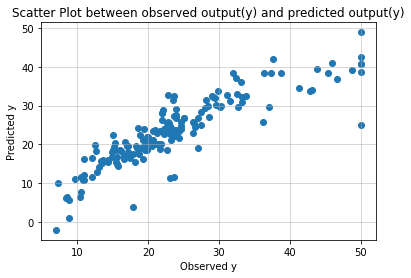

***********************************************************
Mean sq error = 21.47965956874885
Max Number of iteration = 10000


In [101]:

coeff_w, intercept_b, sgd_error = sklearn_implemention_sgd(X_train , X_test ,y_train,y_test,alpha=0.0001, \
                                                           learn_rate='invscaling', eta0=0.01 , n_iteration=10000 )

In [102]:
new=[11, 'SGDRegressor', 0.0001, 'invscaling', 0.01, 0.25, 10000, sgd_error]
output_matrix.loc[10] = new

### 2.6 manual sgd with  n_iter=10000, initial learn_rate=0.01, lr_rate_variation='invscaling'

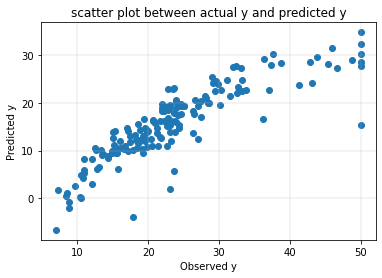

**************************************************************
Error = 86.62525736819876


In [103]:
w, b = manual_sgd(X=X_train_manual, learn_rate ='invscaling' , max_iter=10000)
y_pred = predict(X_test, w, b)
manual_error = plot_scatter(y_test,y_pred)

In [104]:
new=[12, 'manual sgd', 0.0001, 'invscaling', 0.01, 0.25, 10000, manual_error]
output_matrix.loc[11]=new

In [105]:
print('sklearn sgd weight---\n',coeff_w)
print('*********************************************************************************')
print('manual sgd weight---\n',w)

sklearn sgd weight---
 [-1.2806438   0.89945399 -0.37142765  0.33024709 -1.59553429  1.78494539
  0.49164946 -2.71496405  1.81127923 -1.11102419 -2.17240915  1.12867891
 -1.86132837  3.08174583]
*********************************************************************************
manual sgd weight---
 [[-0.60872563  0.50208561 -0.4467399   0.5332908  -0.24448018  2.00515002
  -0.07295664 -0.7322531   0.03519965 -0.43551644 -1.41532162  0.72888833
  -1.77934192  2.18761203]]


In [106]:
percent=abs((coeff_w-w)/w)*100
cnt=0
for i in range(13):
    if (percent[0][i]>30):
        cnt+=1
w_diff.append(cnt)
print('number of points more than 30% in percent=',cnt)

number of points more than 30% in percent= 10


In [107]:
print('sklearn sgd intercept=',intercept_b)
print('manual sgd intercept=',b)
b_diff.append(abs(intercept_b-b))

sklearn sgd intercept= [22.07358311]
manual sgd intercept= [14.4881025]


In [108]:
output_matrix[6:]

,S/No,Algorithm,alpha,lr_rate_variation,init_lr_rate,power_t,n_iter,error
6,7,SGDRegressor,0.0001,invscaling,0.01,0.25,100,21.305162
7,8,manual sgd,0.0001,invscaling,0.01,0.25,100,589.639803
8,9,SGDRegressor,0.0001,invscaling,0.01,0.25,1000,21.420715
9,10,manual sgd,0.0001,invscaling,0.01,0.25,1000,414.045529
10,11,SGDRegressor,0.0001,invscaling,0.01,0.25,10000,21.479660
11,12,manual sgd,0.0001,invscaling,0.01,0.25,10000,86.625257


In [109]:
import tabulate
table2 = [['n_iter', 'no. of points>30% in w', 'difference in intercept'],
         [100,w_diff[0], b_diff[0]], 
         [1000, w_diff[1], b_diff[1]],
         [10000, w_diff[2], b_diff[2]]]
print(tabulate.tabulate(table2, tablefmt='fancy_grid'))


╒════════╤════════════════════════╤═════════════════════════╕
│ n_iter │ no. of points>30% in w │ difference in intercept │
├────────┼────────────────────────┼─────────────────────────┤
│ 100    │ 13                     │ [20.24153]              │
├────────┼────────────────────────┼─────────────────────────┤
│ 1000   │ 9                      │ [10.16762704]           │
├────────┼────────────────────────┼─────────────────────────┤
│ 10000  │ 6                      │ [0.31060573]            │
╘════════╧════════════════════════╧═════════════════════════╛


### Observation :
* By increasing the number of iterations, weights of SGDRegressor and manual sgd becomes more similar
* By increasing the number of iterations, the difference in intercepts of SGDRegressor and manual sgd becomes lesser
* By increasing the number of iteration from 100 to 1000, manual sgd recieves significantly smaller error.However on increasing it to 10000 it remains almost the same.
# However the mean squared error in custom model here with 10000 iterations is much higher than that in constant learning rate model